# 1. Introduction
Time series is a series of data points indexed (or listed or graphed) in time order.

In [1]:
import warnings
warnings.filterwarnings('ignore') #do not disturb mode

import numpy as np #vectors and matrices
import pandas as pd #tables and data manipulations

import matplotlib.pyplot as plt #plots
import seaborn as sns #plots

from dateutil.relativedelta import relativedelta #working with dates
from datetime import date,datetime

from scipy.optimize import minimize #function for minimization

import statsmodels.formula.api as smf #statistics and econometrics
import statsmodels.tsa.api as smt 
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product #useful functions
from tqdm  import tqdm_notebook

import os

%matplotlib inline

In [2]:
sales_df = pd.read_pickle('data/full_df_tsa1.pkl')

In [3]:
sales_df = sales_df[sales_df.date_block_num <= 33]

In [4]:
sales_train_monthly = sales_df.groupby(['date_block_num'])[['item_cnt_month']].sum()
sales_train_monthly.columns = ['item_cnt_month']
#sales_train_monthly.reset_index(inplace=True)

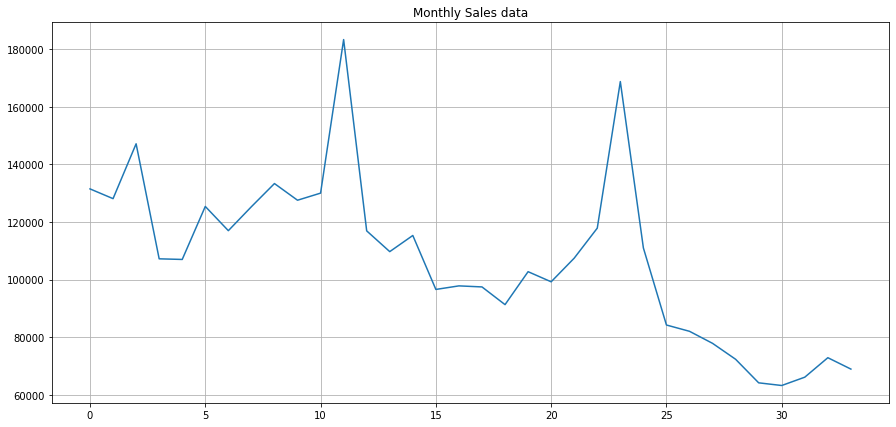

CPU times: user 301 ms, sys: 8.47 ms, total: 309 ms
Wall time: 340 ms


In [5]:
%%time
plt.figure(figsize=(15, 7))
plt.plot(sales_train_monthly['item_cnt_month'])
plt.title('Monthly Sales data')
plt.grid(True)
plt.show()

In [ ]:
del sales_train_monthly
gc.collect();

## Forecast quality metrics

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [6]:
#Importing the above metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

These metrics enable to us to measure the quality of forecasts

# 2. Move, Smooth, Evaluate

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the **moving average**.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [8]:
def moving_avg(series, n):
    '''
        Calculate average of last n observations
    '''
    return np.average(series[-n:])

In [9]:
moving_avg(sales_train_monthly,2)

70865.0

In [9]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Let's smooth by the previous 4 months

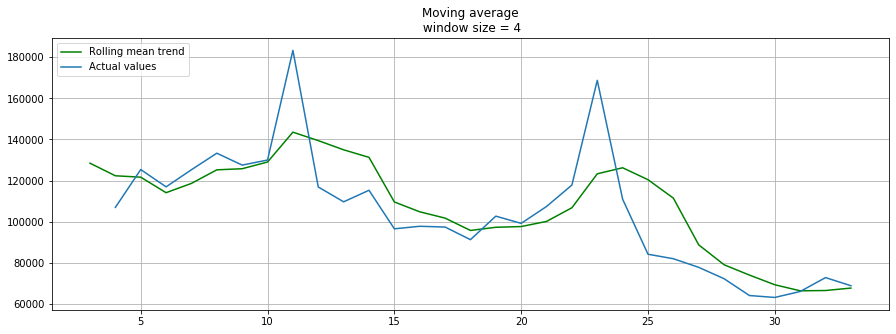

In [11]:
plotMovingAverage(sales_train_monthly, 4) 

Let's smooth by the previous 1 month

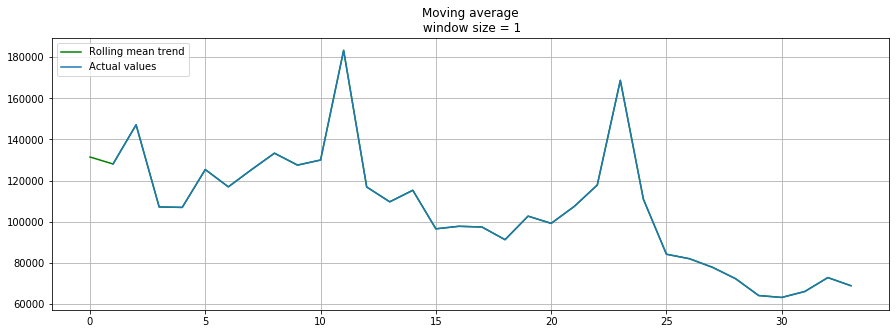

In [12]:
plotMovingAverage(sales_train_monthly, 1) 

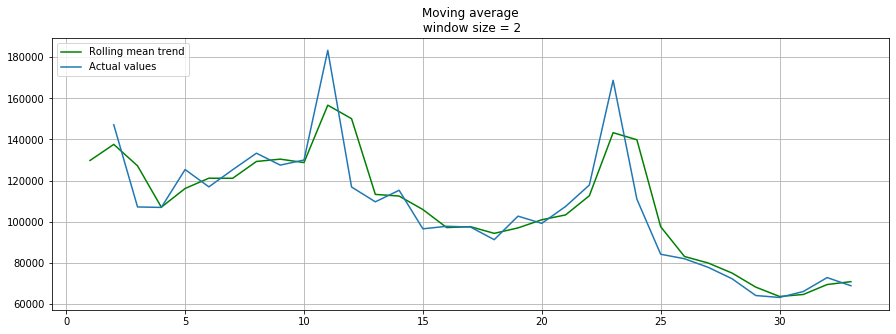

In [13]:
plotMovingAverage(sales_train_monthly, 2) 

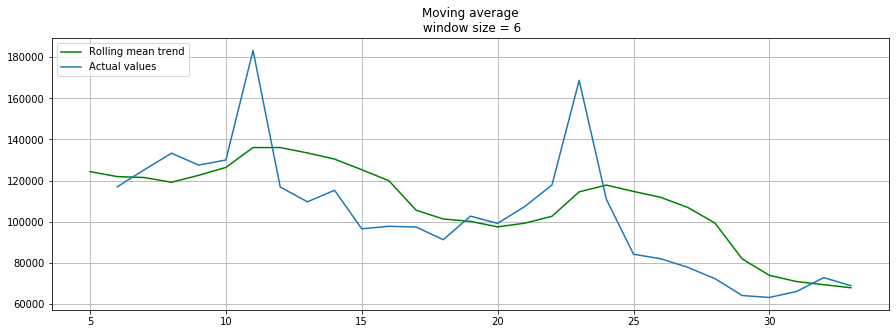

In [14]:
plotMovingAverage(sales_train_monthly, 6) 

We can also plot confidence intervals for our smoothed values

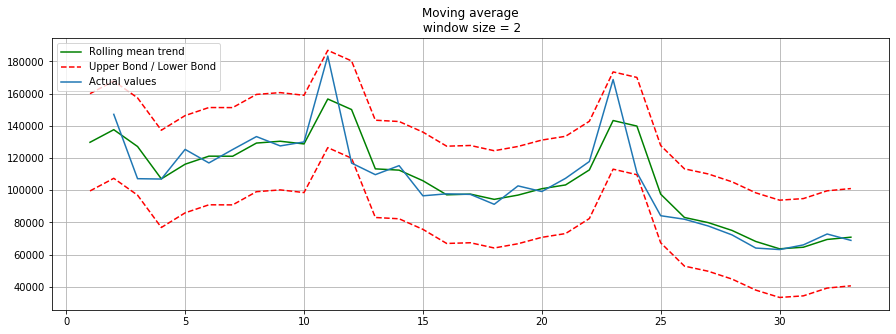

In [15]:
plotMovingAverage(sales_train_monthly, 2, plot_intervals=True)

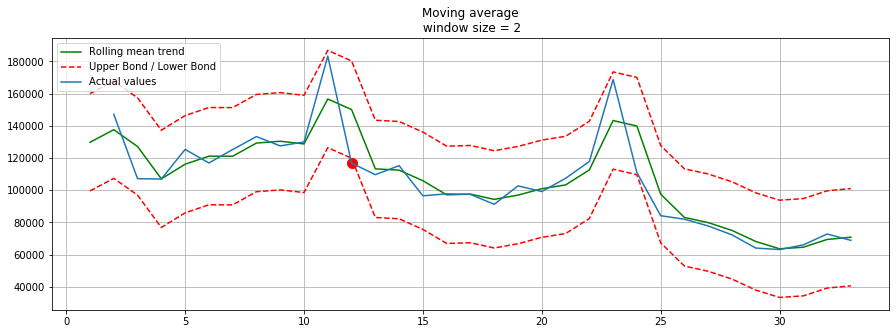

In [16]:
plotMovingAverage(sales_train_monthly, 2, plot_intervals=True, plot_anomalies=True)

The anomaly is seen as there is a drop in sales on date block num 12

In order to avoid false positives, it is recommended to use more complex models.

**Weighted average** is a simple modification to the moving average. The weights sum up to `1` with larger weights assigned to more recent observations.


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$


In [10]:
def weighted_avg(series, weights):
    '''
        Calculate the weighted average on the series
    '''
    result = 00.0
    weights.reverse()
    for n in range(len(weights)):
        result+= series.iloc[-n-1] *weights[n]
    return float(result)

In [18]:
weighted_avg(sales_train_monthly,[0.6,0.3,0.1])

68389.0

## Exponential smoothing

Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for **[exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)** that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [11]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [12]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

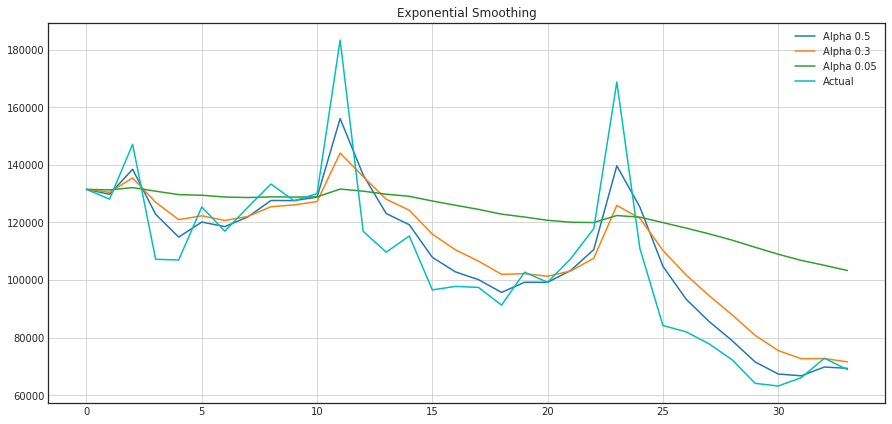

In [21]:
plotExponentialSmoothing(sales_train_monthly['item_cnt_month'], [0.5, 0.3, 0.05])

## Double exponential smoothing

Up to now, the methods that we've discussed have been for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [13]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [14]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

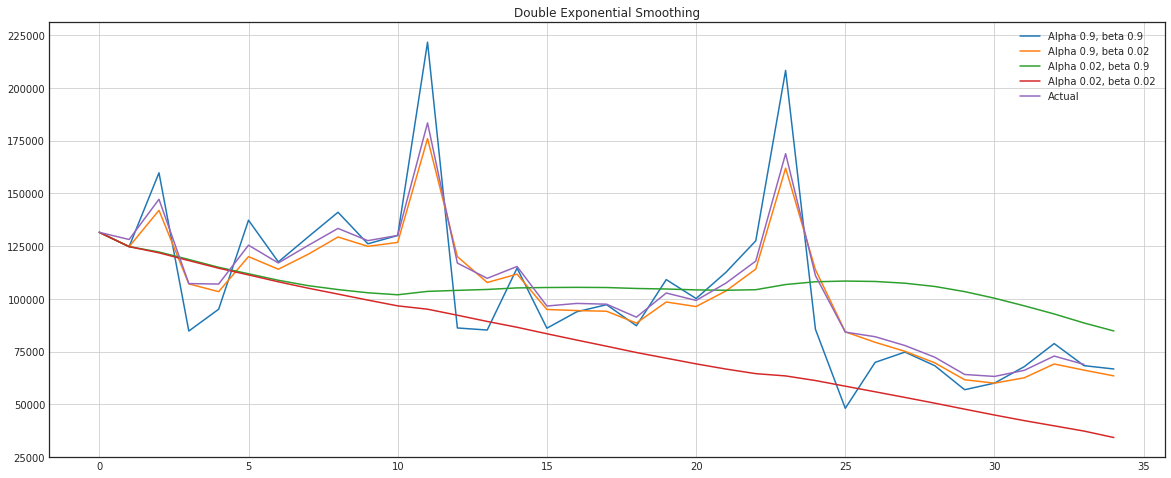

In [24]:
plotDoubleExponentialSmoothing(sales_train_monthly['item_cnt_month'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

Now we have to tune two parameters: α and β. The former is responsible for the series smoothing around the trend, the latter for the smoothing of the trend itself. The larger the values, the more weight the most recent observations will have and the less smoothed the model series will be. Certain combinations of the parameters may produce strange results, especially if set manually. We'll look into choosing parameters automatically in a bit; before that, let's discuss triple exponential smoothing.

## Triple exponential smoothing(Holt-Winters)

As you could have guessed, the idea is to add a third component - seasonality. This means that we should not use this method if our time series is not expected to have seasonality. Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week.

With this, let's write out a new system of equations:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

The intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. You can read more on how averaging works and how the initial approximation of the trend and seasonal components is done. Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary $m$ future steps ahead, which is very encouraging.

Below is the code for a triple exponential smoothing model, which is also known by the last names of its creators, Charles Holt and his student Peter Winters. Additionally, the Brutlag method was included in the model to produce confidence intervals:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$$

where $T$ is the length of the season, $d$ is the predicted deviation. Other parameters were taken from triple exponential smoothing. You can read more about the method and its applicability to anomaly detection in time series.

In [15]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## Time series cross validation

We train our model on a small segment of the time series from the beginning until some $t$, make predictions for the next $t+n$ steps, and calculate an error. Then, we expand our training sample to $t+n$ value, make predictions from $t+n$ until $t+2*n$, and continue moving our test segment of the time series until we hit the last available observation. As a result, we have as many folds as $n$ will fit between the initial training sample and the last observation.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

In [16]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=1):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there's a constraint on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters. In our case, we will use the truncated Newton conjugate gradient.

In [17]:
%%time
data = sales_train_monthly['item_cnt_month'][:-2] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 12, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.05536897178308342 0.04028983060775848 0.07700952172039877
CPU times: user 335 ms, sys: 12 ms, total: 347 ms
Wall time: 341 ms


In [18]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

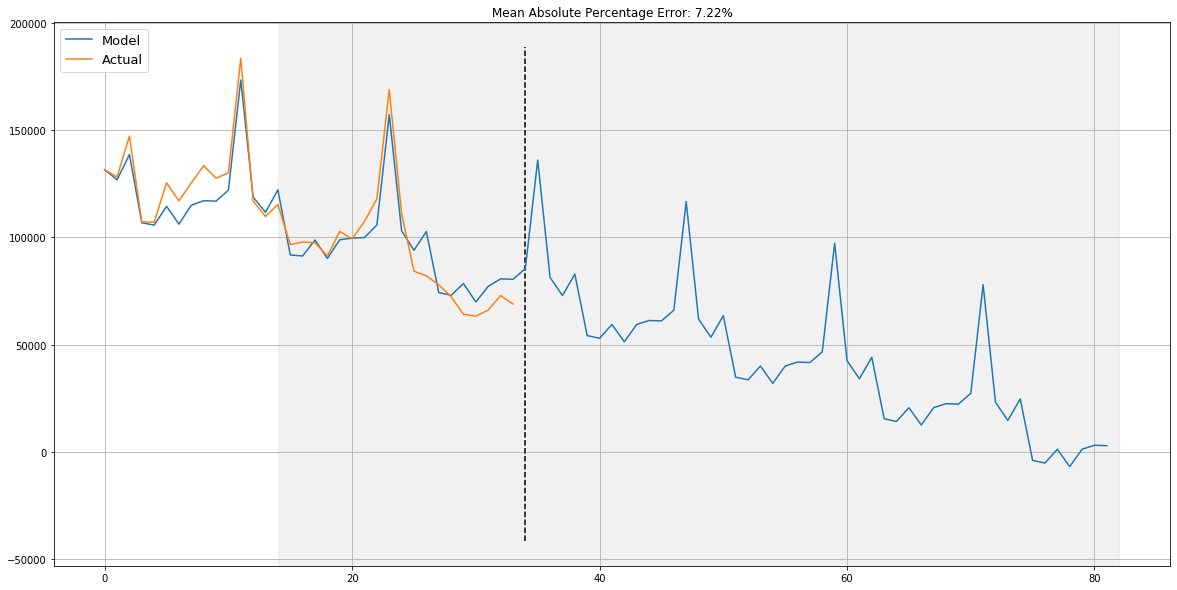

In [42]:
plotHoltWinters(sales_train_monthly['item_cnt_month'])

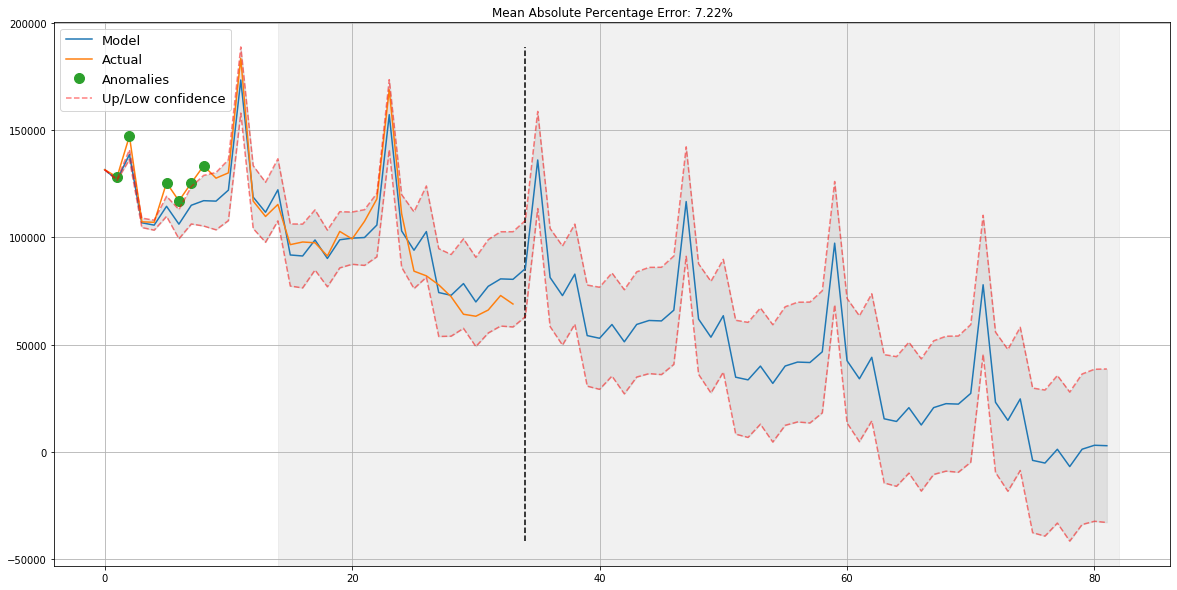

In [43]:
plotHoltWinters(sales_train_monthly['item_cnt_month'], plot_intervals=True, plot_anomalies=True)

Judging by the plots, our model was able to successfully approximate the initial time series, capturing the daily seasonality, overall downwards trend, and even some anomalies. If you look at the model deviations, you can clearly see that the model reacts quite sharply to changes in the structure of the series but then quickly returns the deviation to the normal values, essentially "forgetting" the past. This feature of the model allows us to quickly build anomaly detection systems, even for noisy series data, without spending too much time on preparing the data and training the model.

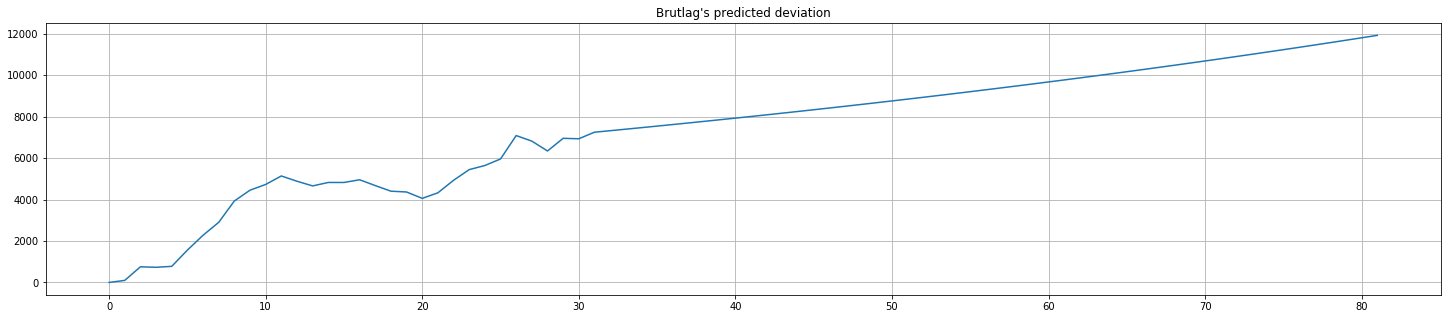

In [44]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

# 3. Econometric Approach

## Stationarity

If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity))The covariance function does not depend on time; it should only depend on the distance between observations.

- The red graph below is not stationary because the mean increases over time.

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- We were unlucky with the variance and see the varying spread of values over time

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice that the spread becomes closer as time increases. Hence, the covariance is not constant with time in the right chart.

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

So why is stationarity so important? Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.

So, in order to combat non-stationarity, we have to know our enemy, so to speak. Let's see how we can detect it. We will look at white noise and random walks.

White noise chart

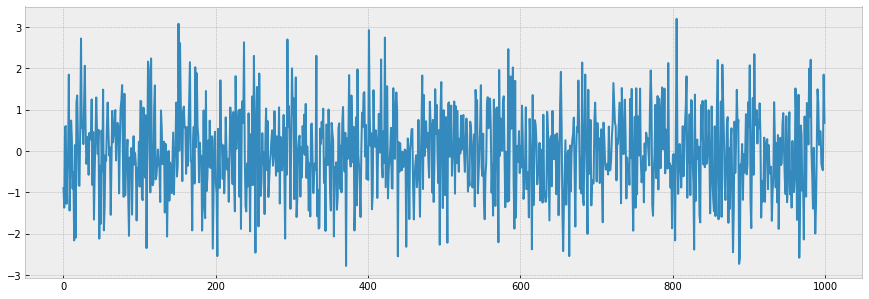

In [32]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

The process generated by the standard normal distribution is stationary and oscillates around 0 with with deviation of 1. Now, based on this process, we will generate a new one where each subsequent value will depend on the previous one: $x_t = \rho x_{t-1} + e_t$ 

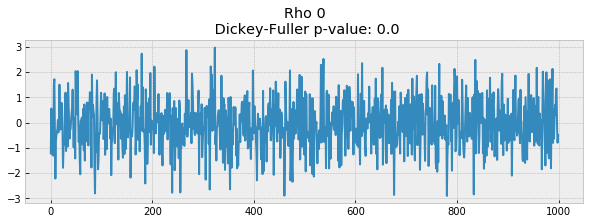

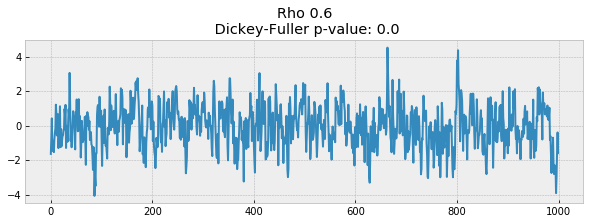

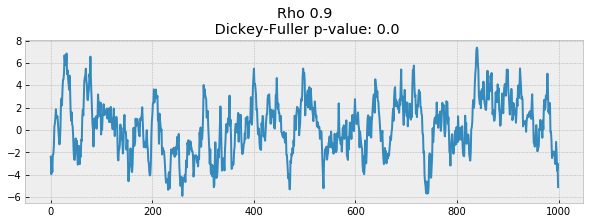

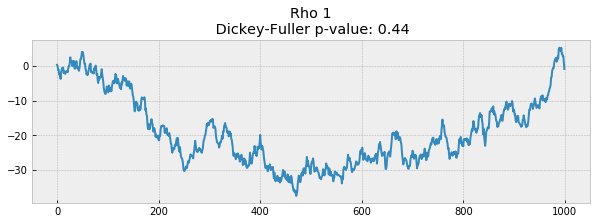

In [33]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

On the first plot, you can see the same stationary white noise as before. On the second plot with $\rho$ increased to 0.6, wider cycles appeared, but it still appears stationary overall. The third plot deviates even more from the 0 mean but still oscillates about the mean. Finally, with $\rho=1$, we have a random walk process i.e. a non-stationary time series.

This happens because, after reaching the critical value, the series $x_t = \rho x_{t-1} + e_t$ does not return to its mean value. If we subtract $x_{t-1}$ from both sides, we will get $x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$, where the expression on the left is referred to as the first difference. If $\rho=1$, then the first difference gives us stationary white noise $e_t$. This is the main idea behind the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) for stationarity of time series (testing the presence of a unit root). If we can get a stationary series from a non-stationary series using the first difference, we call those series integrated of order 1. The null hypothesis of the test is that the time series is non-stationary, which was rejected on the first three plots and finally accepted on the last one. We have to say that the first difference is not always enough to get a stationary series as the process might be integrated of order d, d > 1 (and have multiple unit roots). In such cases, the augmented Dickey-Fuller test is used, which checks multiple lags at once.

We can fight non-stationarity using different approaches: various order differences, trend and seasonality removal, smoothing, and transformations like Box-Cox or logarithmic.

## Getting rid of non-stationarity and building SARIMA

Let's build an ARIMA model

In [19]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

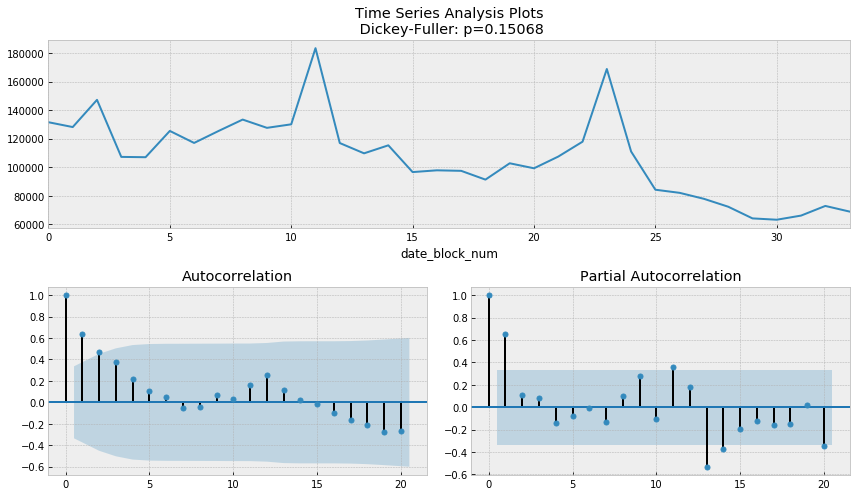

In [46]:
tsplot(sales_train_monthly['item_cnt_month'], lags=20)

The above series is non-stationarity

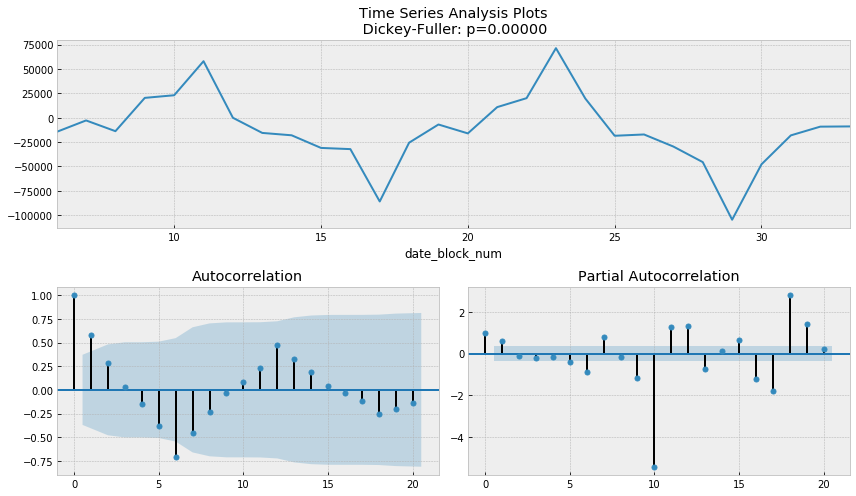

In [50]:
sales_diff = sales_train_monthly['item_cnt_month'] - sales_train_monthly['item_cnt_month'].shift(6)
tsplot(sales_diff[6:], lags=20)

Surprisingly, the second series are stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present. Actually, we can see this on the plot itself -- we do not have a visible trend, so the mean is constant and the variance is pretty much stable. The only thing left is seasonality, which we have to deal with prior to modeling. To do so, let's take the "seasonal difference", which means a simple subtraction of the series from itself with a lag that equals the seasonal period.

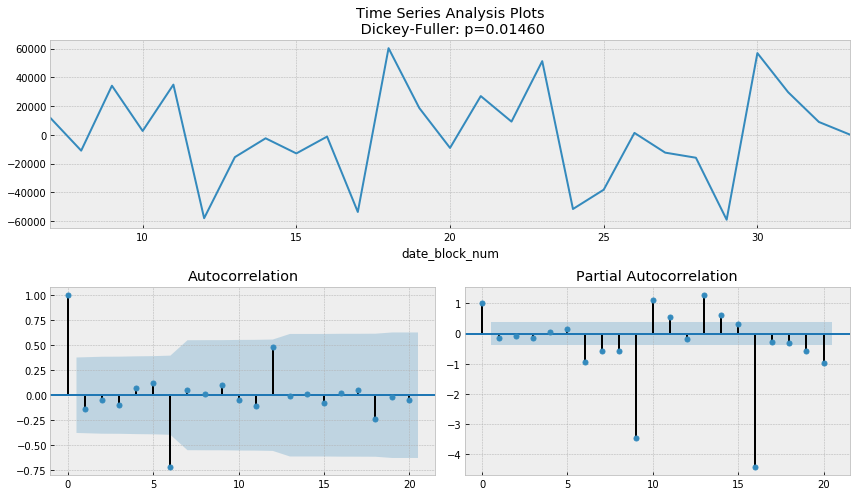

In [51]:
sales_diff = sales_diff - sales_diff.shift(1)
tsplot(sales_diff[6+1:], lags=20)

Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is non-stationary, and the number of significant peaks in ACF has dropped.

## ARIMA-family Crash-Course

We will explain this model by building up letter by letter. $SARIMA(p, d, q)(P, D, Q, s)$, Seasonal Autoregression Moving Average model:

- $AR(p)$ - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as $p$. To determine the initial $p$, you need to look at the PACF plot and find the biggest significant lag after which **most** other lags become insignificant.
- $MA(q)$ - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as $q$. The initial value can be found on the ACF plot with the same logic as before. 

Let's combine our first 4 letters:

$AR(p) + MA(q) = ARMA(p, q)$

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

- $I(d)$ - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences. 

Adding this letter to the four gives us the $ARIMA$ model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

- $S(s)$ - this is responsible for seasonality and equals the season period length of the series

With this, we have three parameters: $(P, D, Q)$

- $P$ - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial $P$ should be 2.

- $Q$ - similar logic using the ACF plot instead.

- $D$ - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

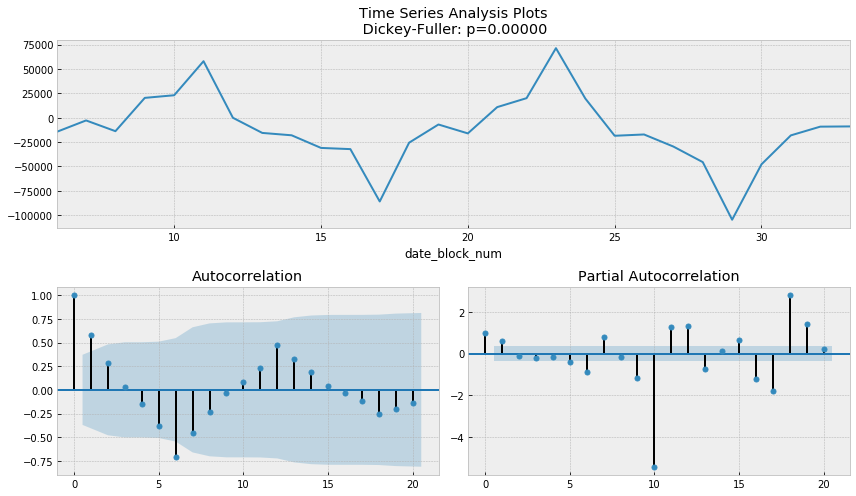

In [20]:
sales_diff = sales_train_monthly['item_cnt_month'] - sales_train_monthly['item_cnt_month'].shift(6)
tsplot(sales_diff[6:], lags=20)

- $p$ is most probably 6 since it is the first significant lag on the PACF
- $d$ equals 1 because series has visible trend( or positive ACF values out to a high number of lags)
- $q$ should be somewhere around 6 as well as seen on the ACF
- $S$ might be 6, since its highest lag in ACF
- $P$ might be 0, ACF is not positive at S
- $D$ again equals 1 because we performed seasonal differentiation
- $Q$ is probably 1. ACF is negative at S

Let's test various models and see which one is better.

In [21]:
# setting initial values and some bounds for them
ps = range(2, 7)#range(2, 5)
d=1 
qs = range(2, 7)
Ps = range(0, 1)#range(0, 2)
D=1 
Qs = range(0, 1)
s = 6 # season length is still 1

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

25

In [56]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(sales_train_monthly['item_cnt_month'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [57]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

/home/vs/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vs/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vs/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vs/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vs/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 


CPU times: user 8.85 s, sys: 29.5 ms, total: 8.88 s
Wall time: 8.89 s


In [58]:
result_table.head()

,parameters,aic
0,"(2, 2, 0, 0)",645.106640
1,"(2, 5, 0, 0)",646.779039
2,"(3, 2, 0, 0)",647.105448
3,"(2, 3, 0, 0)",647.113465
4,"(3, 3, 0, 0)",647.181909


In [59]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(sales_train_monthly['item_cnt_month'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                    item_cnt_month   No. Observations:                   34
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 6)   Log Likelihood                -317.553
Date:                           Wed, 15 Jan 2020   AIC                            645.107
Time:                                   12:01:47   BIC                            651.586
Sample:                                        0   HQIC                           647.033
                                            - 34                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2013      0.317     -0.634      0.526      -0.824       0.421
ar.L2          0.6522      0.327      1.993

Let's inspect the residuals of the model.

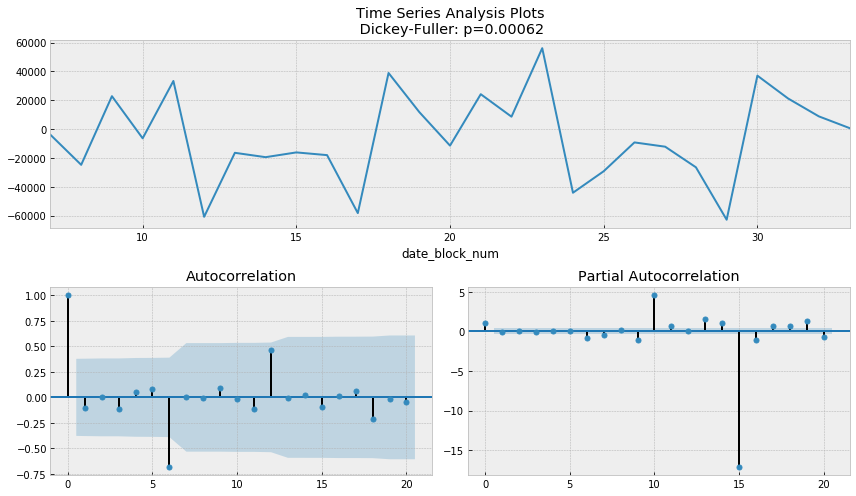

In [60]:
tsplot(best_model.resid[6+1:], lags=20)

It is clear that the residuals are stationary, and there are no apparent autocorrelations. Let's make predictions using our model.

In [61]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

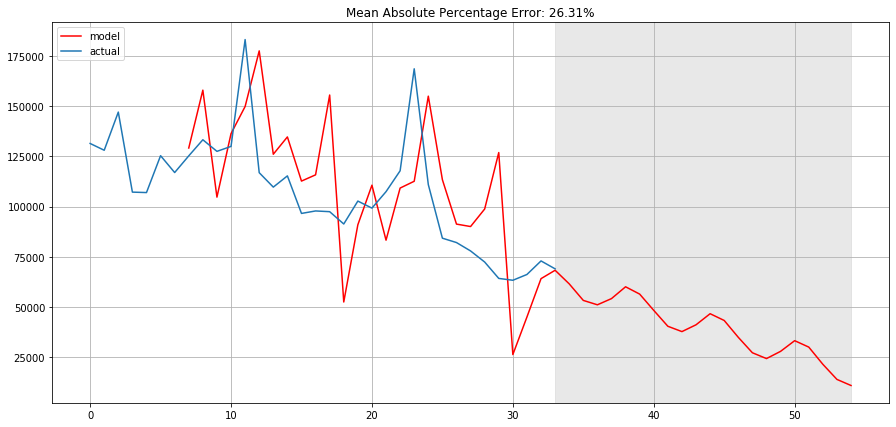

In [62]:
plotSARIMA(sales_train_monthly, best_model, 20)

In the end, we got inadequate predictions. Our model was wrong by 26.31% on average, which may not be appropriate to predict. 

# 4. Linear models on time series

## Feature exctraction
The model needs features:
* Lags of time series
* Window statistics:
    - Max/min value of series in a window
    - Average/median value in a window
    - Window variance
    - etc.
* Target encoding 
* shops , cities, item categories(type/subtype)
* Forecasts from other models 

### Lags of time series
Shifting the series $n$ steps back, we get a feature column where the current value of time series is aligned with its value at time $t-n$. If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.

In [24]:
sales_df = pd.read_pickle('data/full_df_tsa1.pkl')

In [25]:
sales_df.head()

,date_block_num,item_cnt_month,item_id,month,shop_id,year,city,item_category_id,type,subtype
0,0,1.0,27,1,2,2013,Адыгея,19,Игры,PS3
1,0,1.0,33,1,2,2013,Адыгея,37,Кино,Blu
2,0,1.0,317,1,2,2013,Адыгея,45,Книги,Аудиокниги 1С
3,0,1.0,438,1,2,2013,Адыгея,45,Книги,Аудиокниги 1С
4,0,2.0,471,1,2,2013,Адыгея,49,Книги,Методические материалы 1С


In [26]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(3, 8):
    sales_df["lag_{}".format(i)] = sales_df['item_cnt_month'].shift(i)

In [27]:
from utilities import *
import gc

In [28]:
sales_df = downcast_datatypes(sales_df)

In [29]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1823323 entries, 0 to 1823322
Data columns (total 15 columns):
date_block_num      int16
item_cnt_month      float32
item_id             int16
month               int16
shop_id             int16
year                int16
city                object
item_category_id    int16
type                object
subtype             object
lag_3               float32
lag_4               float32
lag_5               float32
lag_6               float32
lag_7               float32
dtypes: float32(6), int16(6), object(3)
memory usage: 118.2+ MB


### Encoding

In [30]:
sales_df['type'] = pd.Categorical(sales_df['type'])
ic_typeDummies = pd.get_dummies(sales_df['type'], prefix = 'type')

sales_df['subtype'] = pd.Categorical(sales_df['subtype'])
ic_subtypeDummies = pd.get_dummies(sales_df['subtype'], prefix = 'subtype')

sales_df['city'] = pd.Categorical(sales_df['city'])
shopsDummies = pd.get_dummies(sales_df['city'], prefix = 'city')

sales_df = pd.concat([sales_df, ic_typeDummies], axis=1)
sales_df = pd.concat([sales_df, ic_subtypeDummies], axis=1)
sales_df = pd.concat([sales_df, shopsDummies], axis=1)

In [31]:
sales_df.drop(['city','subtype','type'], axis=1, inplace=True)

In [32]:
 sales_df.fillna(0, inplace=True)

In [33]:
del ic_typeDummies,ic_subtypeDummies,shopsDummies
gc.collect();

Training a Linear regression model

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [35]:
X_train = sales_df[sales_df['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
Y_train = sales_df[sales_df['date_block_num'] < 33]['item_cnt_month']
X_valid = sales_df[sales_df['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
Y_valid = sales_df[sales_df['date_block_num'] == 33]['item_cnt_month']
X_test = sales_df[sales_df['date_block_num']==34].drop(['item_cnt_month'], axis=1)

In [36]:
X_train

,date_block_num,item_id,month,shop_id,year,item_category_id,lag_3,lag_4,lag_5,lag_6,...,city_Сергиев,city_Сургут,city_Томск,city_Тюмень,city_Уфа,city_Химки,city_Цифровой,city_Чехов,city_Якутск,city_Ярославль
0,0,27,1,2,2013,19,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,33,1,2,2013,37,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,317,1,2,2013,45,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,438,1,2,2013,45,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,471,1,2,2013,49,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577587,32,22087,9,59,2015,83,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1577588,32,22088,9,59,2015,83,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1577589,32,22091,9,59,2015,83,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1577590,32,22100,9,59,2015,42,3.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1


In [89]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [96]:
def plotModelResults(model, X_train=X_train, X_valid=X_valid, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_valid)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(Y_valid.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, Y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(Y_valid))
            anomalies[Y_valid<lower] = Y_valid[Y_valid<lower]
            anomalies[Y_valid>upper] = Y_valid[Y_valid>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, Y_valid)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

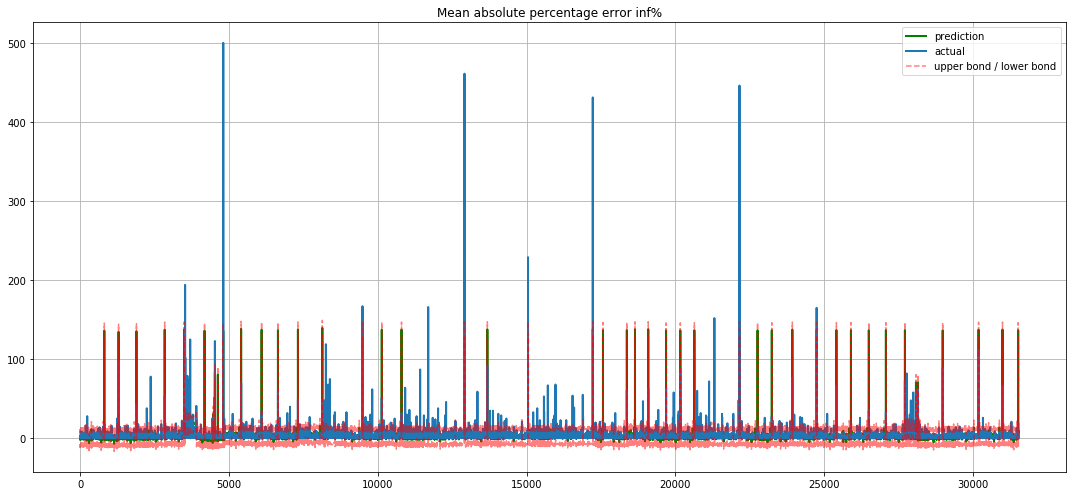

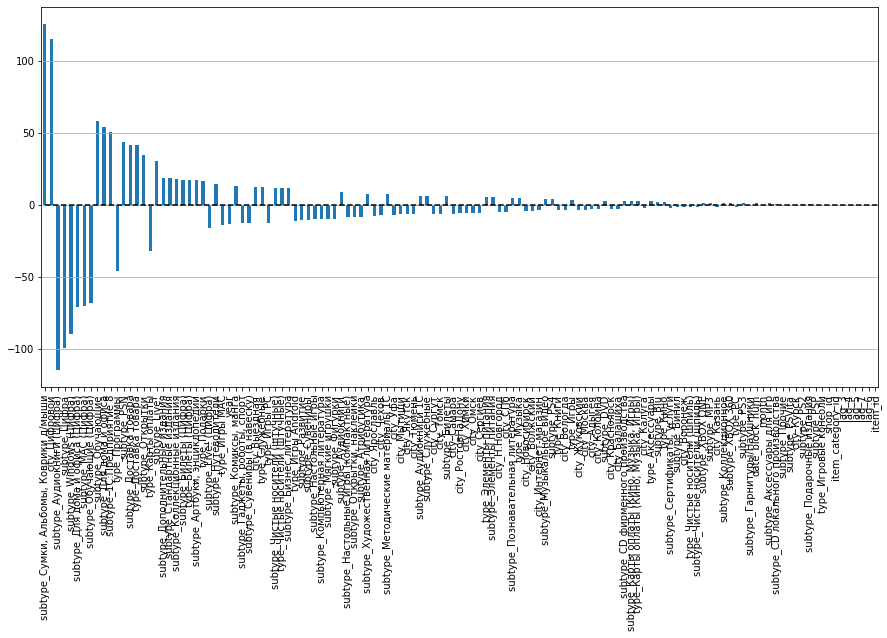

In [97]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Since we now have different scales in our variables, thousands for the lag features and tens for categorical, we need to transform them into same scale for exploring feature importance and, later, regularization. 

In [98]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

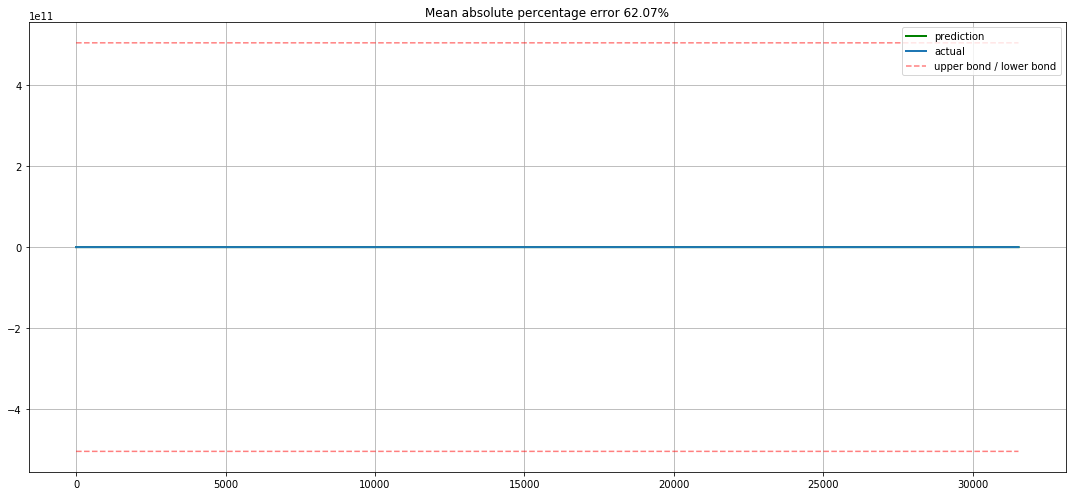

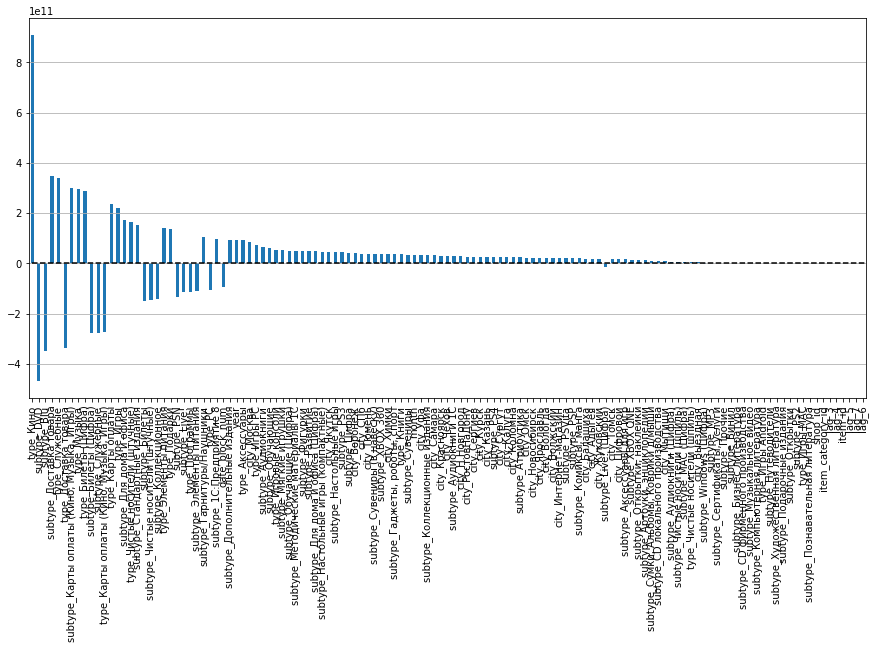

In [99]:
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

lr = LinearRegression()
lr.fit(X_train_scaled, Y_train)

plotModelResults(lr, X_train=X_train_scaled, X_valid=X_valid_scaled, plot_intervals=True)
plotCoefficients(lr)

## Regularization and feature selection

As we already know, not all features are equally healthy -- some may lead to overfitting while others should be removed. Besides manual inspection, we can apply regularization. Two of the most popular regression models with regularization are Ridge and Lasso regressions. They both add some more constrains to our loss function. 

In the case of Ridge regression, those constraints are the sum of squares of the coefficients multiplied by the regularization coefficient. The bigger the coefficient a feature has, the bigger our loss will be. Hence, we will try to optimize the model while keeping the coefficients fairly low. 

As a result of this $L2$ regularization, we will have higher bias and lower variance, so the model will generalize better (at least that's what we hope will happen).

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values of the coefficients. As a result, during the optimization process, coefficients of unimportant features may become zeroes, which allows for automated feature selection. This regularization type is called $L1$. 

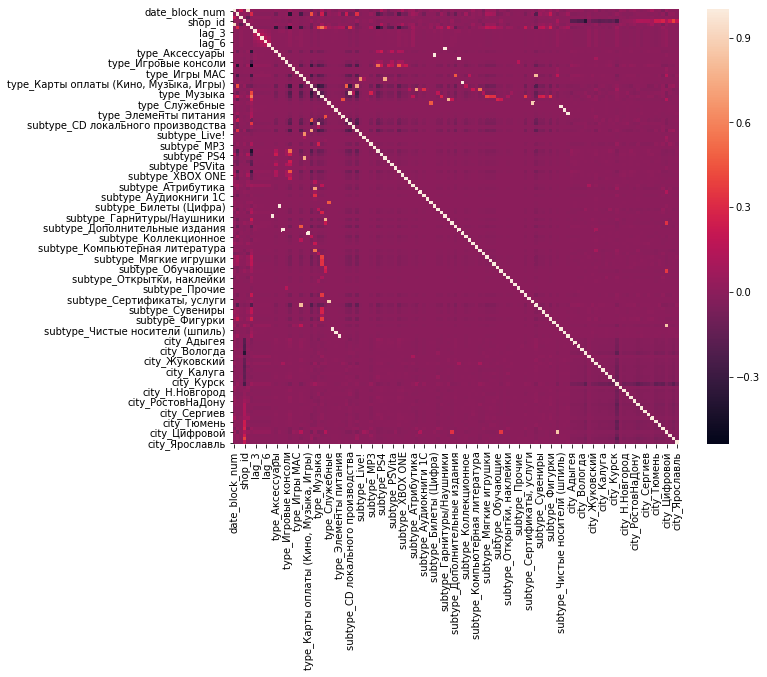

In [100]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

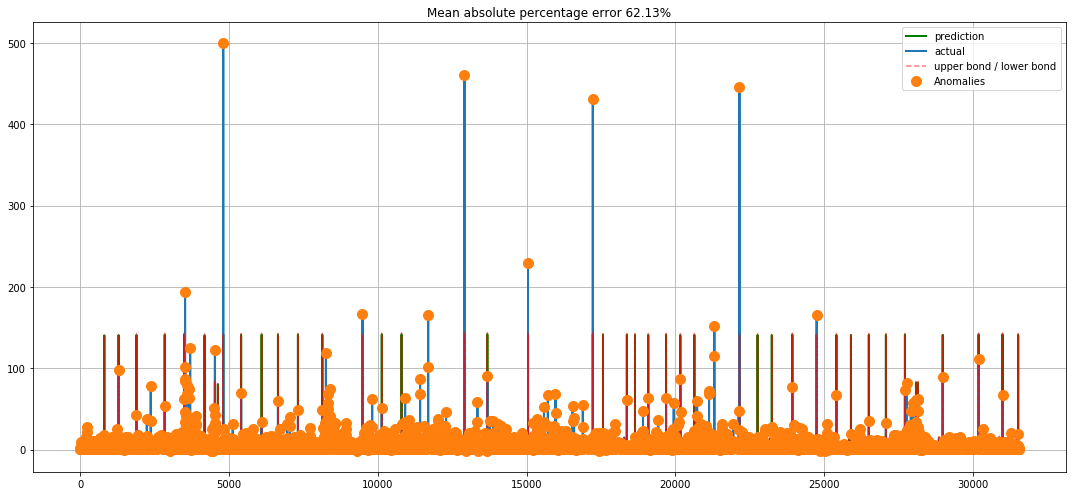

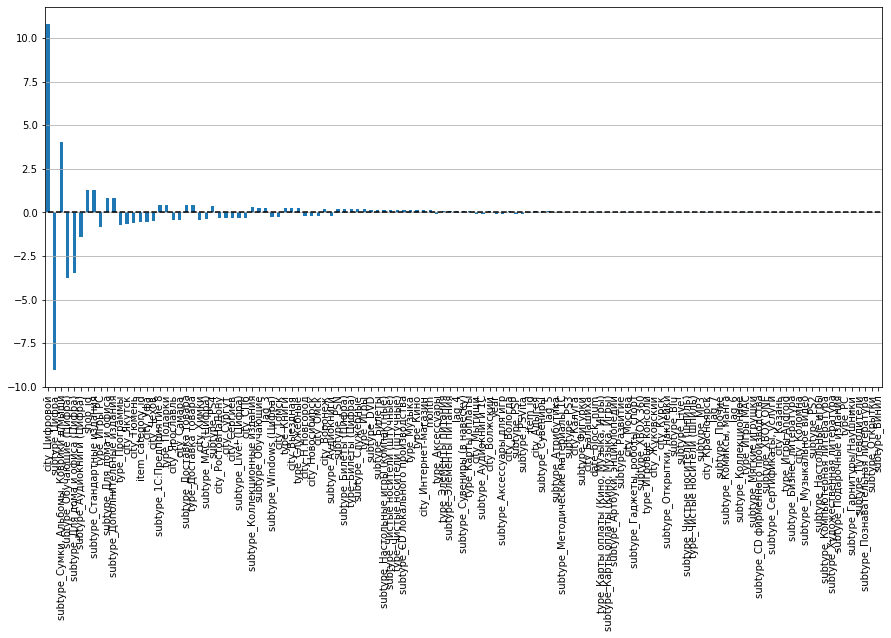

In [102]:
%%time
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, Y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_valid=X_valid_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

We can clearly see some coefficients are getting closer and closer to zero (though they never actually reach it) as their importance in the model drops.

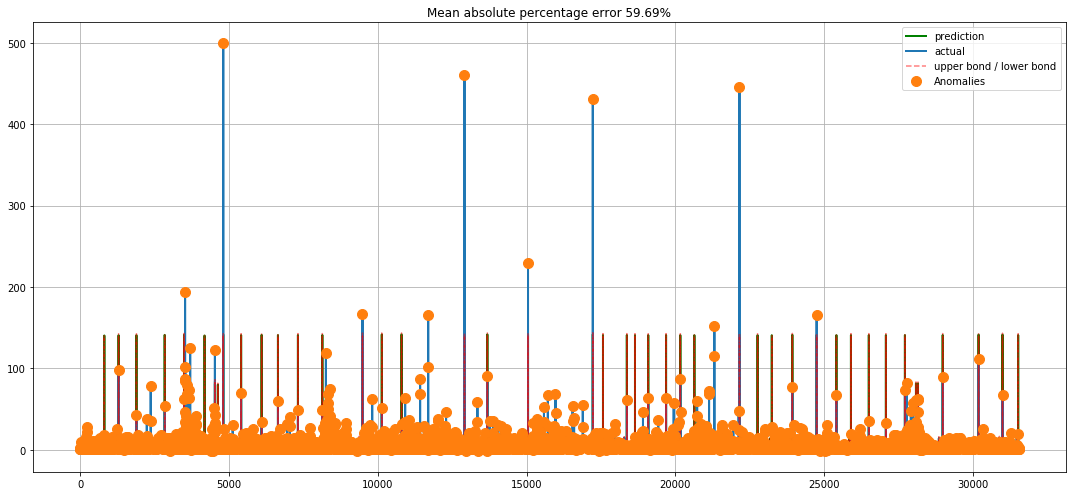

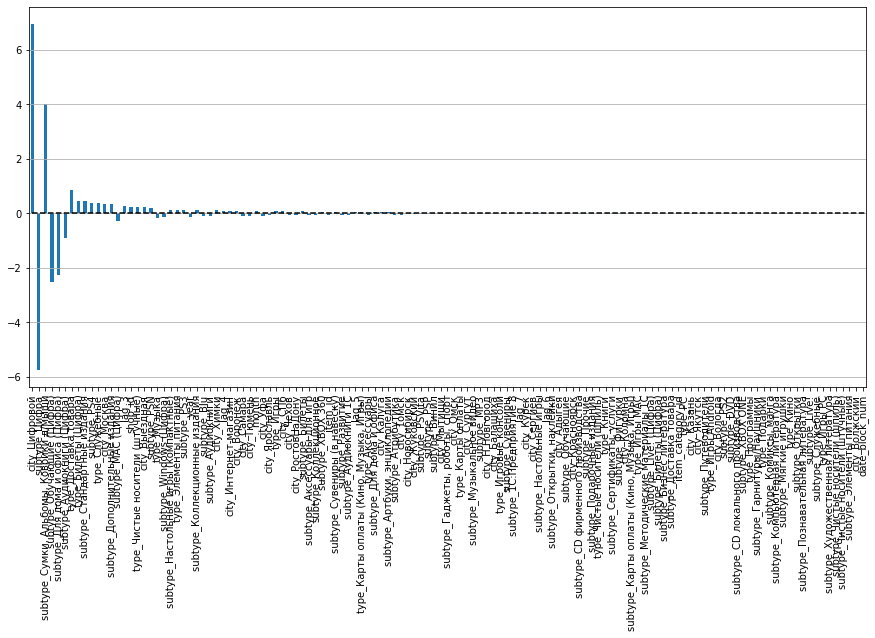

In [104]:
%%time
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, Y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_valid=X_valid_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

## Boosting 

In [121]:
from xgboost import XGBRegressor 

xgb = XGBRegressor(tree_method='gpu_hist',seed=42)
xgb.fit(X_train_scaled, Y_train)

[22:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

[22:08:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


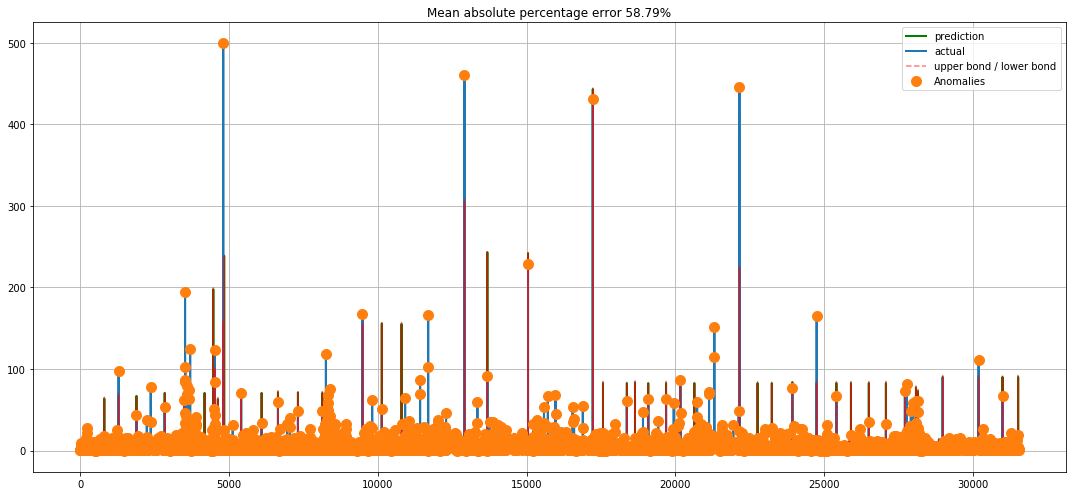

In [122]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_valid=X_valid_scaled, 
                 plot_intervals=True, plot_anomalies=True)